### Import libraries

In [531]:
# Import library
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

# Import LinearRegression model from Scikit-Learn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer

### Import files

In [532]:
anime_data = pd.read_csv('../anime_cleaned.csv')

### Removing some blank data

In [533]:
anime_data['episodes'].replace('', np.nan, inplace=True)
anime_data.dropna(subset=['episodes'], inplace=True)
anime_data['episodes'] = anime_data['episodes'].astype('int64')
anime_data['main genre'].replace('Supernatural', np.nan, inplace=True)
anime_data.dropna(subset=['main genre'], inplace=True)
linreg = LinearRegression()

In [534]:
boardcast_cat = ['Sundays',
                 'Mondays',
                 'Tuesdays',
                 'Wednesdays',
                 'Thursdays',
                 'Fridays',
                 'Saturdays',
                 'Not schedule',
                 'Unknown']

### Helper function

In [535]:
def linear_regression(predictors, numeric_predictors, cat_predictors_nominal, cat_predictors_ordinal, response):
    # Extract Response and Predictors
    y = pd.DataFrame(anime_data[response])
    X = pd.DataFrame(anime_data[predictors])

    oe = OrdinalEncoder(categories=[boardcast_cat])
    ohe = OneHotEncoder(sparse=False)
    
    oe.fit_transform(X[cat_predictors_ordinal])
    ohe.fit_transform(X[cat_predictors_nominal])

    column_transformer = make_column_transformer(
        (RobustScaler(), numeric_predictors),
        (oe, cat_predictors_ordinal),
        (ohe, cat_predictors_nominal))
        
    column_transformer.fit_transform(X)
    
    # Split the Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
    
    # Linear Regression using Train Data
    lm_pipeline = make_pipeline(column_transformer, linreg)
    # linreg = LinearRegression()         # create the linear regression object
    lm_pipeline.fit(X_train, y_train)        # train the linear regression model
    
    # Coefficients of the Linear Regression line
    print('Intercept of Regression \t: b = ', linreg.intercept_)
    print('Coefficients of Regression \t: a = ', linreg.coef_)
    print()
    
    # Print the Coefficients against Predictors
    print(pd.DataFrame(list(zip(X_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
    print()
    
    # Predict Response corresponding to Predictors
    y_train_pred = lm_pipeline.predict(X_train)
    y_test_pred =  lm_pipeline.predict(X_test)
    
    # Plot the Predictions vs the True values
    f, axes = plt.subplots(1, 2, figsize=(24, 12))
    axes[0].scatter(y_train, y_train_pred, color = "blue")
    axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
    axes[0].set_xlabel("True values of the Response Variable (Train)")
    axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
    axes[1].scatter(y_test, y_test_pred, color = "green")
    axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
    axes[1].set_xlabel("True values of the Response Variable (Test)")
    axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
    plt.show()
    
    print()
    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Explained Variance (R^2) \t:", lm_pipeline.score(X_train, y_train))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
    print()
    
    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Explained Variance (R^2) \t:", lm_pipeline.score(X_test, y_test))
    print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
    print()
    return lm_pipeline

### Predicting `score` with `episodes` and `duration`

Intercept of Regression 	: b =  [7.27224585]
Coefficients of Regression 	: a =  [[-0.45194715  0.01140038  0.04945847 -0.00333161 -0.03339464  0.06360962
  -0.16879132  0.26888213 -0.19435734 -0.14606351  0.05949389 -0.34150078
  -0.19845678  0.30339991  0.01395087 -0.03211381  0.18172113 -0.39472999
  -0.01970554 -0.35830297 -0.03794723  1.03430634 -0.10129044  0.1272915
  -0.09514115  0.00861931  0.06806457 -0.00754379 -0.0843575   0.00276646
  -0.08415239  0.08726485 -0.03162734  0.05139925 -0.04829937  0.1860196
   0.07723084 -0.05784534 -0.0832614  -0.09928318 -0.10786449 -0.10525083
   0.33358272 -0.03632186  0.01730246 -0.0325585  -0.09363273  0.1878656
  -0.07897684]]

        Predictors  Coefficients
0       popularity     -0.451947
1         duration      0.011400
2  scored_by_users      0.049458
3        broadcast     -0.003332
4           source     -0.033395
5      demographic      0.063610
6       main genre     -0.168791
7        premiered      0.268882



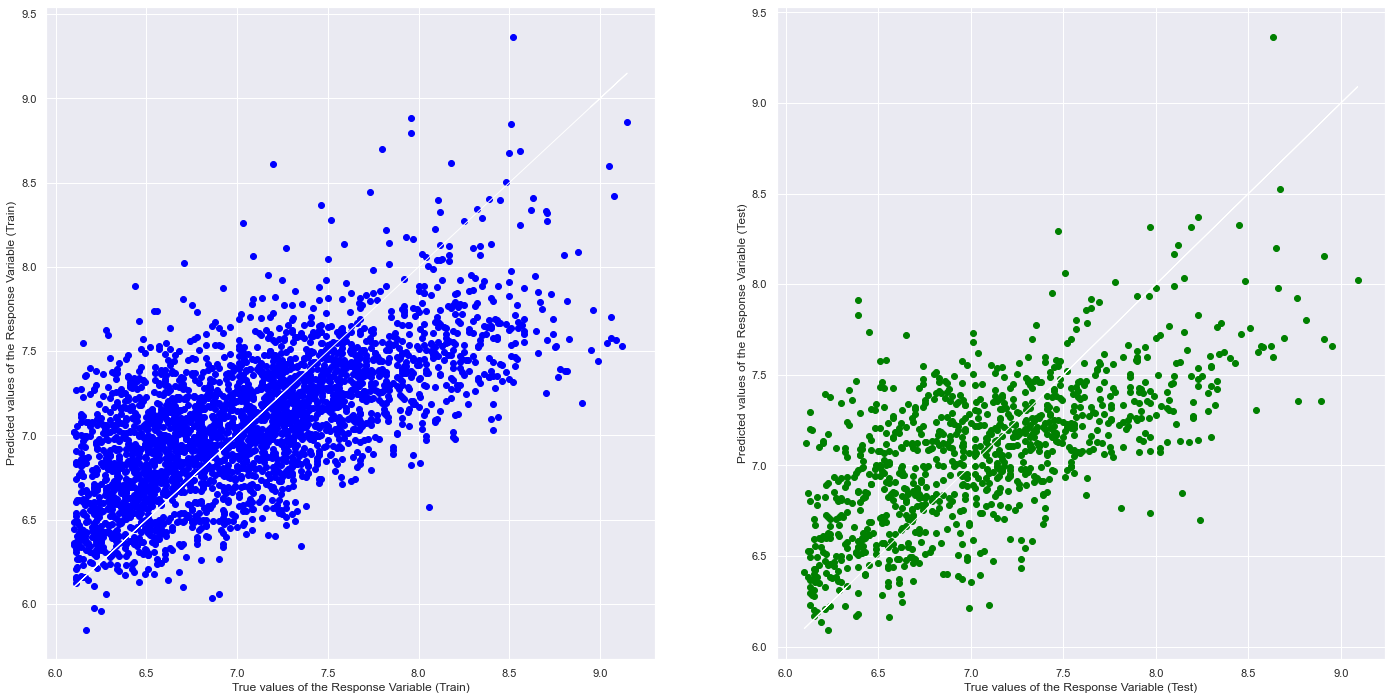


Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.44748668615754883
Mean Squared Error (MSE) 	: 0.21403296690833942

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.4383633348768451
Mean Squared Error (MSE) 	: 0.20766573919211703



In [536]:
lm_pipeline = linear_regression(['popularity', 'duration', 'scored_by_users', 'broadcast', 'source', 'demographic', 'main genre', 'premiered'],
                                ['popularity', 'duration', 'scored_by_users'], 
                                ['source', 'demographic', 'main genre', 'premiered'], 
                                ['broadcast'], 'score')

#### Prediction

In [537]:
# Extract Pokemons for Prediction
anime_pred = anime_data[anime_data["title"].isin(["Steins;Gate", "Dr. Stone", "One Piece", "Mobile Suit Gundam 00",
                                                 "Naruto: Shippuuden", "Jujutsu Kaisen", "Re:Zero kara Hajimeru Isekai Seikatsu 2nd Season Part 2", "Magical Nyan Nyan Taruto"])]
anime_pred


,Unnamed: 0,Unnamed: 0.1,rank,title,score,scored_by_users,type,episodes,status,year aired,...,studios,source,genres,main genre,theme,demographic,duration,rating,popularity,url
2,2,2,3,Steins;Gate,9.09,1161139,TV,24,Finished Airing,2011,...,White Fox,Visual novel,"Drama, Sci-Fi, Suspense",Drama,Psychological,All,24,PG-13 - Teens 13 or older,13,https://myanimelist.net/anime/9253/Steins_Gate
43,56,56,107,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Seas...,8.51,335734,TV,12,Finished Airing,2021,...,White Fox,Light novel,"Drama, Fantasy, Suspense",Drama,Psychological,All,28,R - 17+ (violence & profanity),244,https://myanimelist.net/anime/42203/Re_Zero_ka...
100,161,161,1062,Jujutsu Kaisen,7.71,9325,ONA,3,Finished Airing,2018,...,Yokohama Animation Lab,Manga,NaN,Unknown,Unknown,Shounen,1,G - All Ages,2918,https://myanimelist.net/anime/38777/Jujutsu_Ka...
650,1184,1184,235,Dr. Stone,8.30,791619,TV,24,Finished Airing,2019,...,TMS Entertainment,Manga,"Adventure, Comedy, Sci-Fi",Adventure,Unknown,Shounen,24,PG-13 - Teens 13 or older,60,https://myanimelist.net/anime/38691/Dr_Stone
938,1739,1739,290,Naruto: Shippuuden,8.23,1201683,TV,500,Finished Airing,2007,...,Studio Pierrot,Manga,"Action, Adventure, Comedy",Action,Unknown,Shounen,23,PG-13 - Teens 13 or older,16,https://myanimelist.net/anime/1735/Naruto__Shi...
1759,3350,3350,401,Mobile Suit Gundam 00,8.12,109152,TV,25,Finished Airing,2007,...,Sunrise,Original,"Action, Drama, Sci-Fi",Action,Unknown,All,24,R - 17+ (violence & profanity),945,https://myanimelist.net/anime/2581/Mobile_Suit...
2277,4467,4467,68,One Piece,8.62,1014947,TV,1013,Currently Airing,1999,...,Toei Animation,Manga,"Action, Adventure, Comedy, Drama, Fantasy",Action,Super Power,Shounen,24,PG-13 - Teens 13 or older,26,https://myanimelist.net/anime/21/One_Piece
3681,7498,7498,7699,Magical Nyan Nyan Taruto,6.21,1741,TV,12,Finished Airing,2001,...,"Madhouse, TNK",Unknown,NaN,Unknown,Unknown,All,22,G - All Ages,6431,https://myanimelist.net/anime/952/Magical_Nyan...


In [538]:
# Extract Predictors for Prediction
X_pred = pd.DataFrame(anime_pred[['popularity', 'duration', 'scored_by_users', 'broadcast', 'source', 'demographic', 'main genre', 'premiered']])

# linreg = LinearRegression()
# Predict Response corresponding to Predictors
y_pred = lm_pipeline.predict(X_pred)
y_pred

array([[8.02556807],
       [7.53787439],
       [7.20457879],
       [8.11236302],
       [8.37337427],
       [7.35886327],
       [8.33966448],
       [6.69657589]])

In [539]:
# Summarize the Actuals, Predictions and Errors
y_pred = pd.DataFrame(y_pred, columns = ["PredScore"], index = anime_pred.index)
animedata_acc = pd.concat([anime_pred[["title", "score"]], y_pred], axis = 1)

y_errs = 100 * abs(animedata_acc["score"] - animedata_acc["PredScore"]) / animedata_acc["score"]
y_errs = pd.DataFrame(y_errs, columns = ["Error"], index = anime_pred.index)
animedata_acc= pd.concat([animedata_acc, y_errs], axis = 1)

animedata_acc

,title,score,PredScore,Error
2,Steins;Gate,9.09,8.025568,11.709922
43,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Seas...,8.51,7.537874,11.423333
100,Jujutsu Kaisen,7.71,7.204579,6.555398
650,Dr. Stone,8.30,8.112363,2.260687
938,Naruto: Shippuuden,8.23,8.373374,1.742093
1759,Mobile Suit Gundam 00,8.12,7.358863,9.373605
2277,One Piece,8.62,8.339664,3.252152
3681,Magical Nyan Nyan Taruto,6.21,6.696576,7.835361
